In [1]:
# data_ext = preprocess_houses(data, df_poi = df_poi, impute = False, impute_dummies = False, augment = True, add_pois = True, radii = [0.5,2,5,10,20])

# should i leave df_poi directly in the processing script?

# ML Challenge 2023
student: Bruno Zorrilla
Kaggle username: elzorroo

---

<a id="table"></a> 

# Table of Contents

* [Introduction](#intro)
* [Part 0: setting up environment](#section-zero)
* [Part 1: Data Exploration](#section-one)
    - [1.1 Data Visualization](#subsection-one-one)
    - [1.2 Data Cleaning](#subsection-one-two)
        - 1.2.1 missing data
        - 1.2.2 outliers
    - [1.3 Feature Engineering](#subsection-one-three)
    - [1.4 Mixing the ingredients](#subsection-one-four)
* [ Part 2 : Modelling ](#section-two)
    - [2.1 splitting the data](#subsection-two-one)
    - [2.2 modelling](#subsection-two-two)
    - [2.3 comparing models](#subsection-two-three)
    
* [Part 3: A-B testing / CV](#section-three)
* [Conclusion](#conclusion)

# Introduction
<a id="intro"></a> 
In this notebook, we'll get an inital understanding of the data and then try to clean in and augment it in such a way that its usefulness is maximized.
The goal of the project is predicting house prices in different Italian cities. There's access to two datasets.

1. In `train.csv` you will find a set of rows, each containing data for one apartment for sale. The target variable that you have to predict is the sale price.
2. `poi.csv` contains the coordinates of points of insterest that you can use to further enrich the features available in your training dataset.

<a id="section-zero"></a> 


| [back](#intro) | [back to table of contents](#table) | [next](#section-one)|
 | - | ----------------------------------- | - |
---
# Part 0: setting up our environment





## 0.1 Install necessary dependencies and scripts

we install useful packages such as pandas, matplotlib, etc

Additionally, I provided a script called **preprocess_houseprices** in which I defined a function that automatically does most of the basic preprocessing as well as the heavy-load preprocessing, such as feature augmentation with points of interest. Its workings will be detailed in the following section.

In [2]:
#upload some useful libraries
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler # will be very useful
from scipy import stats
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# models
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from tensorflow import keras
from xgboost import XGBRegressor as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV

# warnings.filterwarnings('ignore')

print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)
%matplotlib inline

TensorFlow v2.11.0
TensorFlow Decision Forests v1.2.0


In [3]:
### ADDING UTILITY SCRIPTS

#!ls /kaggle/usr/lib/{name_of_utility_scripts}
#import {name_of_utility_scripts}

#!ls /kaggle/usr/lib/autotrain
from preprocess_houseprices import preprocess_houses
# data_ext = preprocess_houses(data, df_poi = df_poi, impute = False, impute_dummies = False, augment = True, add_pois = True, radii = [0.5,2,5,10,20])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DtypeWarning: Columns (7,9,11,13,17,18,19,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,74,77,80,82,83,84,85,86,87,90,91,92,95) have mixed types.Specify dtype option on import or set low_memory=False.
  import sys


## 0.2 loading data

Let's load the test, train, and points of interest datasets and display some key characteristics from each:

---

- `df_train` 46.3 thousand houses in training dataset
- `df_test` 19.9 thousand houses in test dataset
- `df_poi` **397.4 thousand points of interest**

Additionally, I'm loading simultaneously two preprocessed datasets to avoid the computational cost of the feature engineering each time. The details
of the these will be detailed in the section on feature engineering.

- `aug_train` 46.3 thousand houses in training dataset, with additional features: "city", dummy for each city, and pois in x km radius [0.5, 2, 5, 10, 20]
- `aug_test` 19.9 thousand houses in test dataset, with same additional features

In [4]:
df_train = pd.read_csv('/kaggle/input/ml-challenge-2023-30412/train.csv')
#df_poi = pd.read_csv('/kaggle/input/ml-challenge-2023-30412/poi.csv')
df_test = pd.read_csv('/kaggle/input/ml-challenge-2023-30412/test_updated.csv')

data = df_train.copy()
cols = list(data.columns); cols.pop(1); cols
df_test.reindex(columns = cols) # reordering fields to follow the same as train data

data = df_test.copy()

In [5]:
df_test.head(3)

,id,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
0,18825,True,Nuovo / Nuova costruzione,2010.0,41.917500,12.655400,175.0,1.0,3.0,True,1.0,1.0,5.0,2.0,1.0,72.0
1,30956,NaN,Buono stato / Abitabile,1900.0,45.446100,12.326700,175.0,0.0,0.0,True,1.0,NaN,3.0,2.0,1.0,60.0
2,47193,NaN,Buono stato / Abitabile,NaN,45.456925,9.194406,NaN,NaN,-1.0,NaN,3.0,0.0,NaN,3.0,1.0,140.0


In [6]:
df_train.head(3)

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
0,10461,60000,True,Buono stato / Abitabile,1980.0,41.901300,12.700000,175.0,30.0,2.0,NaN,1.0,NaN,3.0,1.0,1.0,35.0
1,51304,900000,NaN,Buono stato / Abitabile,NaN,41.907017,12.481311,NaN,NaN,3.0,NaN,1.0,1.0,NaN,3.0,1.0,131.0
2,33032,33000,NaN,Buono stato / Abitabile,1960.0,41.976500,12.440500,204.2,30.0,4.0,NaN,1.0,NaN,4.0,1.0,1.0,16.0


In [7]:
df_poi = pd.read_csv('/kaggle/input/ml-challenge-2023-30412/poi.csv')

df_poi = df_poi[["id_on_platform", "lat", "lon"]]
df_poi  =df_poi.rename(columns = {"id_on_platform": "id", "lat": "latitude", "lon" : "longitude"})

# ignore weird warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (7,9,11,13,17,18,19,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,74,77,80,82,83,84,85,86,87,90,91,92,95) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
# augmented datasets with most preprocessing done
aug_train = pd.read_csv('/kaggle/input/augmented/train_pipe.csv')
aug_test = pd.read_csv('/kaggle/input/augmented/test_pipe_updated.csv')

In [9]:
aug_train.columns

Index(['id', 'price', 'balcony', 'conditions', 'construction_year', 'latitude',
       'longitude', 'energy_efficiency', 'expenses', 'floor', 'garden',
       'n_bathrooms', 'elevator', 'total_floors', 'n_rooms',
       'proximity_to_center', 'surface', 'milan', 'rome', 'venice',
       'center_dist', 'city', 'pois_0.5km', 'pois_2km', 'pois_5km',
       'pois_10km', 'pois_20km'],
      dtype='object')

<a id="section-one"></a> 

| [back](#section-zero) | [back to table of contents](#table) | [next](#section-two)|
 | - | ----------------------------------- | - |
---
# Part 1 - Data Exploration




here we'll take an inital look at the data and make relevant observations

In [10]:
# looking at missing data
data = df_train
total_train = data.isnull().sum().sort_values(ascending=False)
percent_train = np.round( (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100, 1)

data = df_test
total_test = data.isnull().sum().sort_values(ascending=False)
percent_test = np.round ( (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100, 1 )

missing_data = pd.concat([total_train, percent_train, total_test, percent_test], axis=1, keys=['total missing train', '%  train', 'total missing test', '% test'])
missing_data

,total missing train,% train,total missing test,% test
garden,31529,68.1,13443.0,67.9
energy_efficiency,19903,43.0,8570.0,43.3
total_floors,18349,39.6,7938.0,40.1
elevator,17443,37.7,7455.0,37.7
expenses,16154,34.9,6971.0,35.2
balcony,15443,33.3,6732.0,34.0
construction_year,13946,30.1,5964.0,30.1
n_bathrooms,2416,5.2,951.0,4.8
floor,2031,4.4,876.0,4.4
conditions,1229,2.7,511.0,2.6


the fields top 7 fields are missing <30% of the data; however, looking closely, 'garden' and 'elevator' are both booleans where NaN seems to correspond more closely to 'False', as in both cases only True or NaNs exist. That seems like a quick fix

#### Univariate study: target variable
we begin by looking at the target variable, `price`. from the following numbers and graphs, its is evident that the house prices are not normally distributed. Nonetheless. the distribution of log prices approaches that distribution.

In [11]:
df_train['price'].describe()

count    4.631200e+04
mean     5.031879e+05
std      1.106504e+06
min      1.540000e+02
25%      1.990000e+05
50%      3.150000e+05
75%      5.150000e+05
max      7.200000e+07
Name: price, dtype: float64

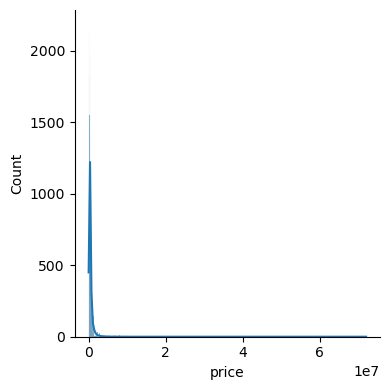

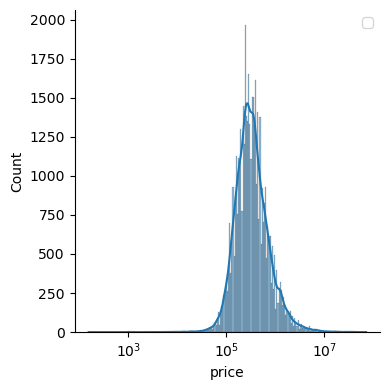

In [12]:
sns.displot(df_train['price'], kde = True, height = 4)
sns.displot(df_train['price'] , log_scale = True, kde = True, height = 4 )
plt.legend()
plt.show()

we also look at the houseprices per city and observe their differences, especially with respect to the mean

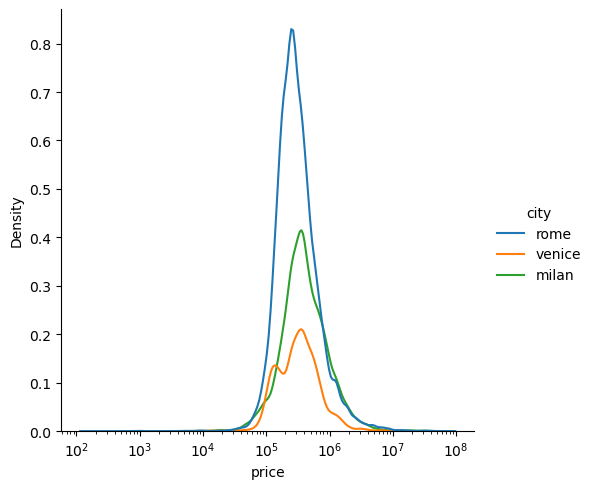

In [13]:
sns.displot(data = aug_train, x = 'price', kind = 'kde', hue = "city", log_scale = True)

In [14]:
milan_prices = aug_train[aug_train['city'] == 'milan']
m = milan_prices['price'].describe()

rome_prices = aug_train[aug_train['city'] == 'rome']
r= rome_prices['price'].describe()

venice_prices = aug_train[aug_train['city'] == 'venice']
v= venice_prices['price'].describe()

price_by_city = pd.concat([m,r,v], axis = 1, keys= ['price milan', 'price rome', 'price venice'])
price_by_city

,price milan,price rome,price venice
count,1.407700e+04,2.495700e+04,7.265000e+03
mean,6.015218e+05,4.609747e+05,4.575324e+05
std,1.133130e+06,1.080419e+06,1.131486e+06
min,1.100000e+03,1.540000e+02,6.500000e+02
25%,2.400000e+05,1.898000e+05,1.800000e+05
50%,3.780000e+05,2.800000e+05,3.200000e+05
75%,6.500000e+05,4.490000e+05,5.000000e+05
max,4.000000e+07,7.200000e+07,6.200000e+07


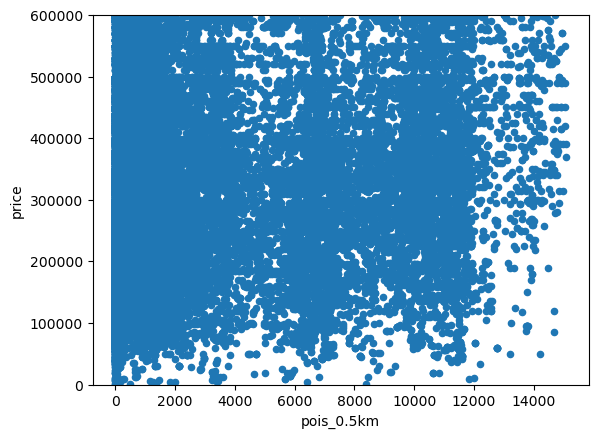

In [15]:
#scatter plot grlivarea/saleprice
var = 'pois_0.5km'
data = pd.concat([aug_train['price'], aug_train[var]], axis=1)
data.plot.scatter(x=var, y='price',ylim= (0,6e+05));

### side-by-side comparisons in train and test data

In [16]:
cat = 'surface'
a = aug_train[cat].describe()
b = aug_test[cat].describe()

desc = pd.concat([a,b], axis = 1, keys = [f'train {cat}', f'test {cat}']); desc

,train surface,test surface
count,45772.000000,19596.000000
mean,115.110045,115.307052
std,88.586419,89.538459
min,1.000000,10.000000
25%,68.000000,67.000000
50%,91.000000,90.000000
75%,130.000000,130.000000
max,990.000000,990.000000


<a id="section-one-one"></a> 

---
## 1.1 - Data Visualization

here, we look at correlations between explanatory variables as well as correlations with the targat variable itself. the following correlation heatmap includes only the original variables, while the one after provides an extended matrix with all added features (explained in the feature enginnering section).


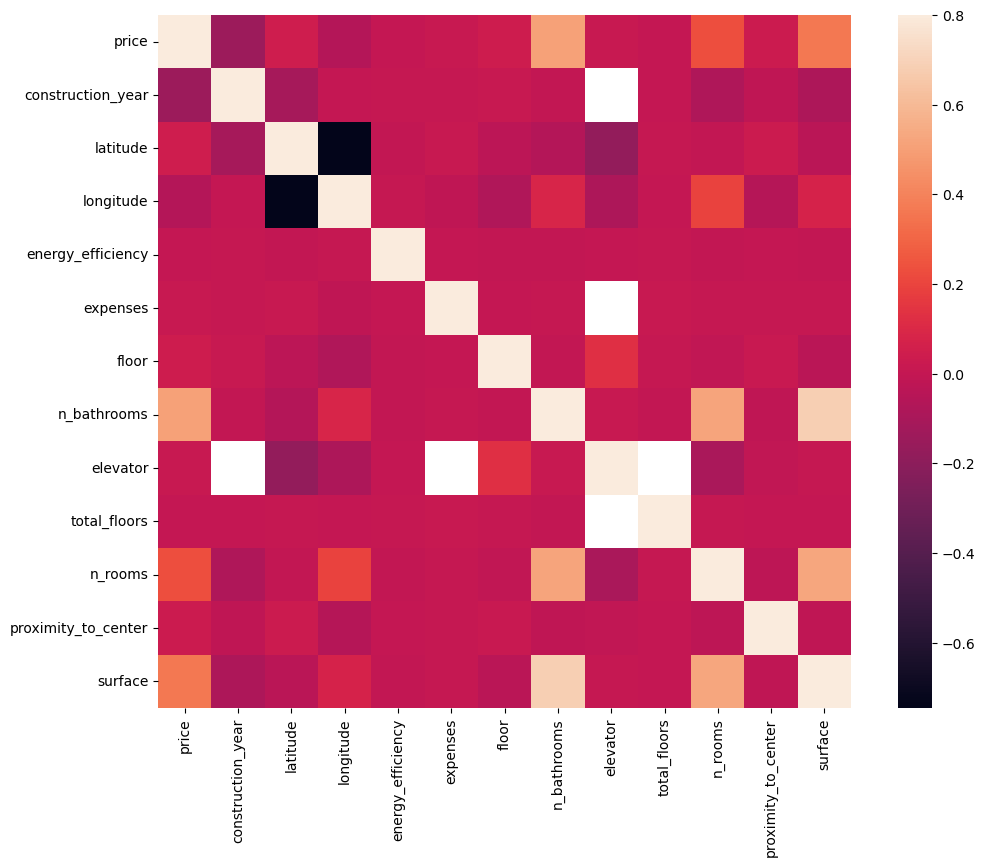

In [17]:
#correlation matrix
data = df_train
corrmat = (data.iloc[: , 1:]).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

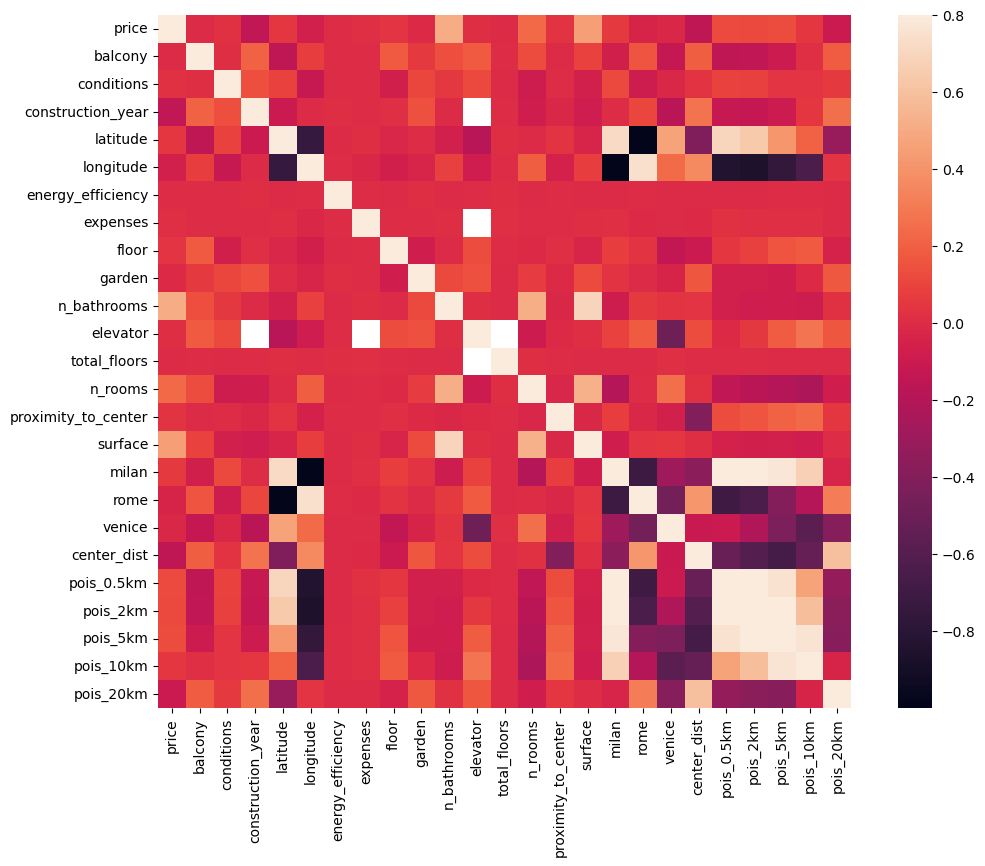

In [18]:
#correlation matrix
data = aug_train
corrmat = (data.iloc[: , 1:]).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

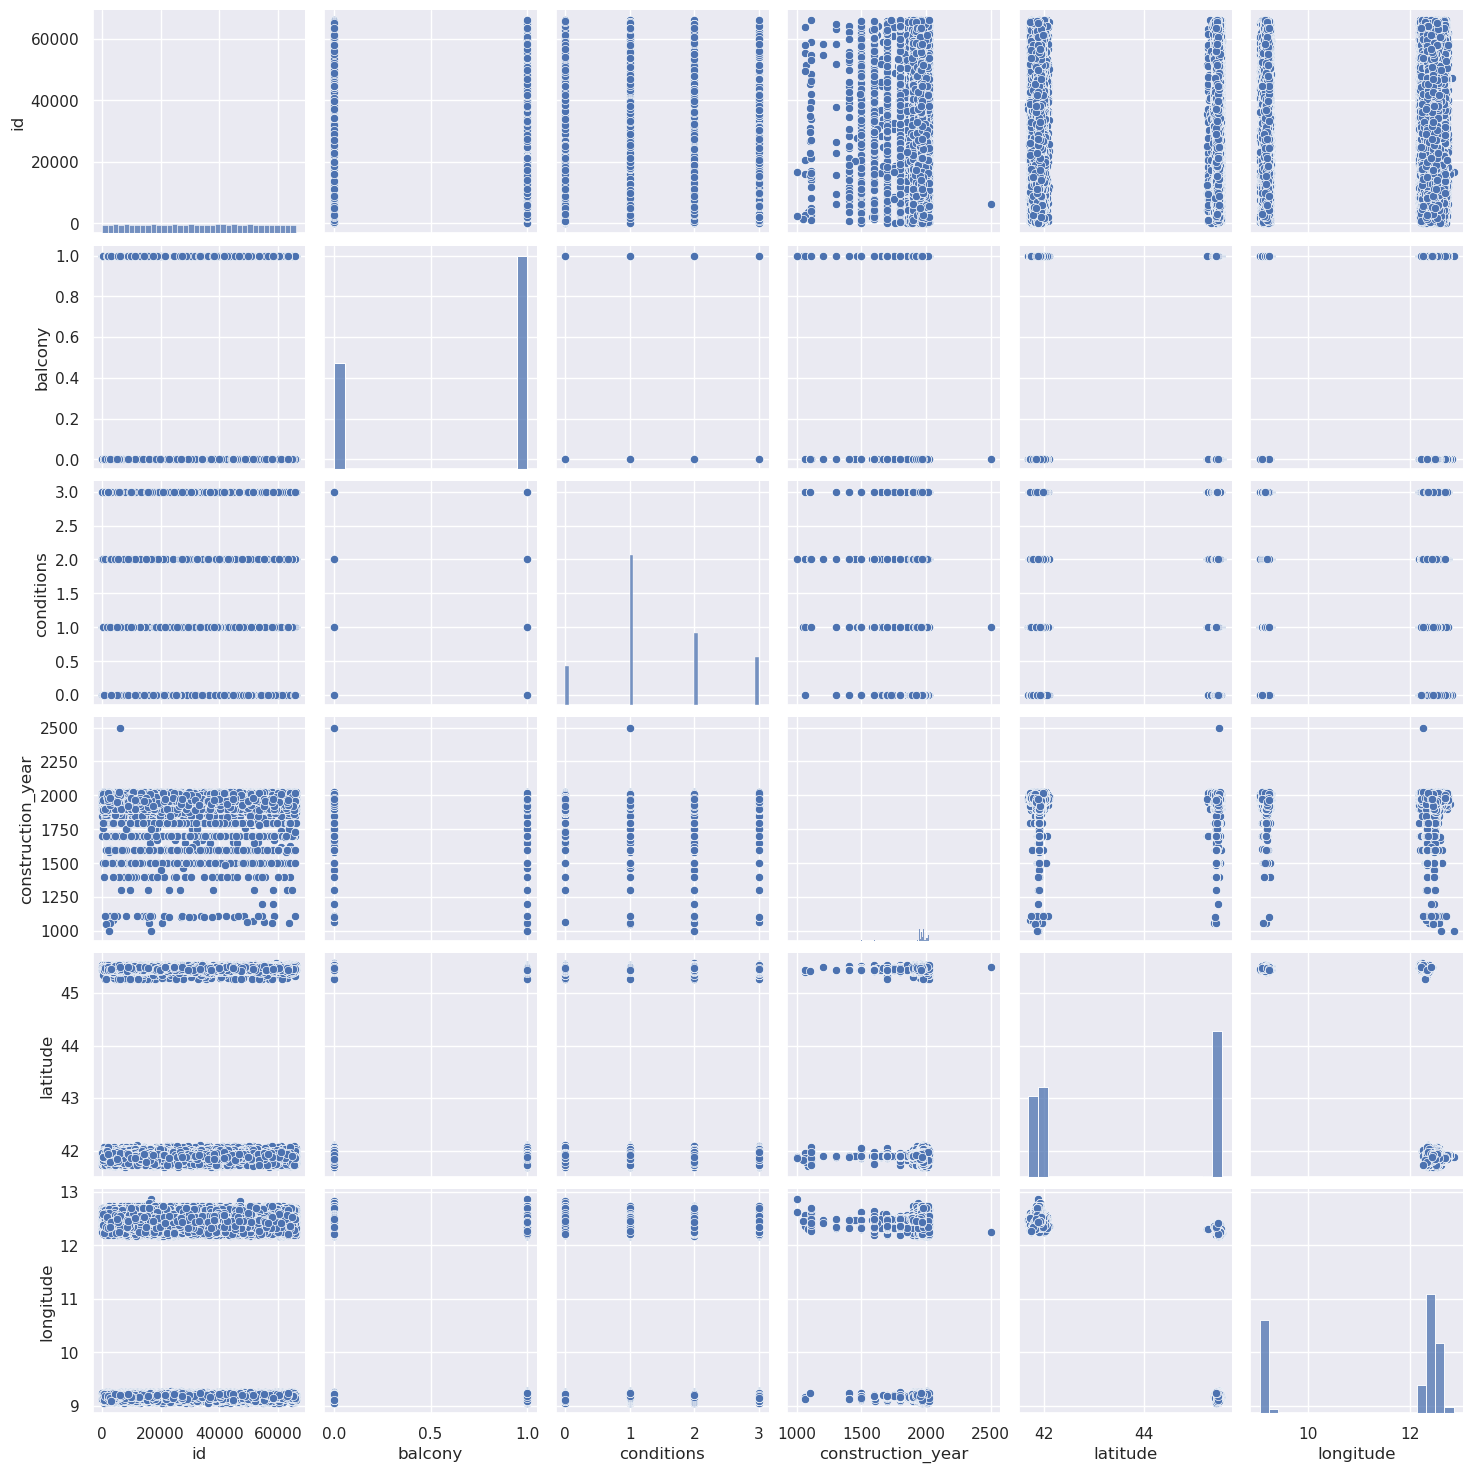

In [19]:
#scatterplot
sns.set()
cols

# cap price outliers
data['price'] = data['price'].clip(upper=6e+5)

sns.pairplot(data[cols].iloc[:,:6], size = 2.5)
plt.show();

clearly, the count of points of interests for different radii around a house are correlated with one another, as well as with the city in which the house is located. this provides strong evidence for the need to eliminate some of them when training the final model. we now look at a finer detail, observing **the most corralated variables by city**:

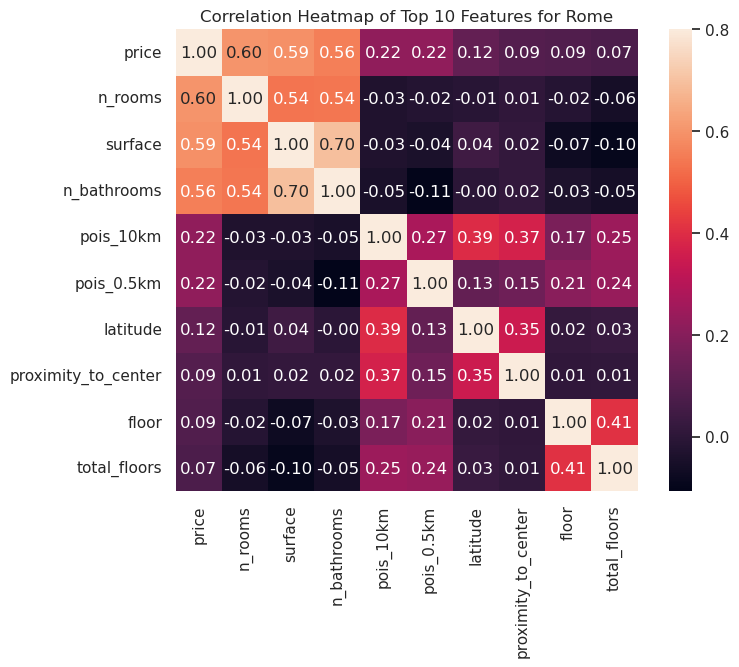

In [20]:
data = aug_train[aug_train['city'] == 'rome'].drop(['pois_2km', 'pois_5km',
       'pois_20km'], axis = 1)
corrmat = (data.iloc[: , 1:]).corr()
k = 10 #number of variables for heamap
cols = corrmat.nlargest(k, 'price')['price'].index
corrmat = (data[cols]).corr()
f, ax = plt.subplots(figsize=(8,6))
sns.set(font_scale=1)
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f');
ax.set_title(f"Correlation Heatmap of Top {k} Features for Rome")
plt.show()

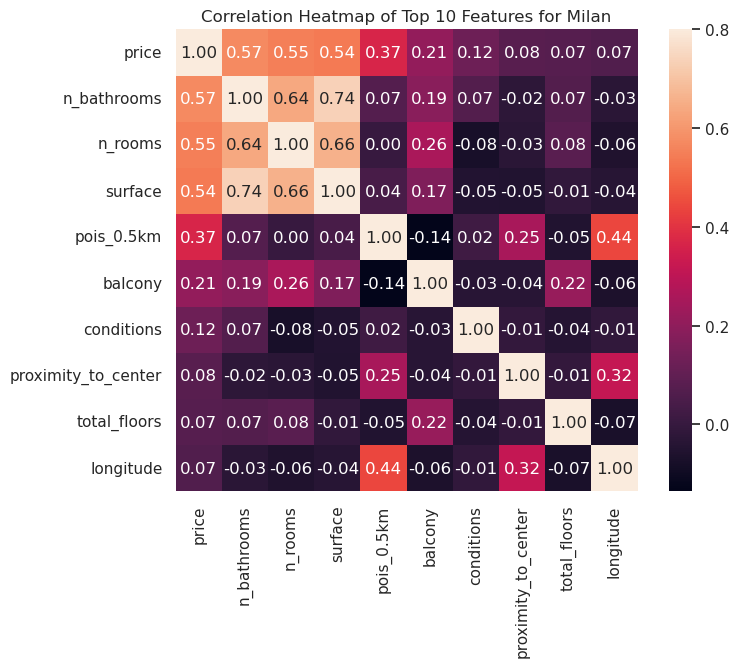

In [21]:
data = aug_train[aug_train['city'] == 'milan'].drop(['pois_2km', 'pois_5km',
       'pois_20km'], axis = 1)
corrmat = (data.iloc[: , 1:]).corr()
k = 10 #number of variables for heamap
cols = corrmat.nlargest(k, 'price')['price'].index
corrmat = (data[cols]).corr()
f, ax = plt.subplots(figsize=(8,6))
sns.set(font_scale=1)
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f');
ax.set_title(f"Correlation Heatmap of Top {k} Features for Milan")
plt.show()

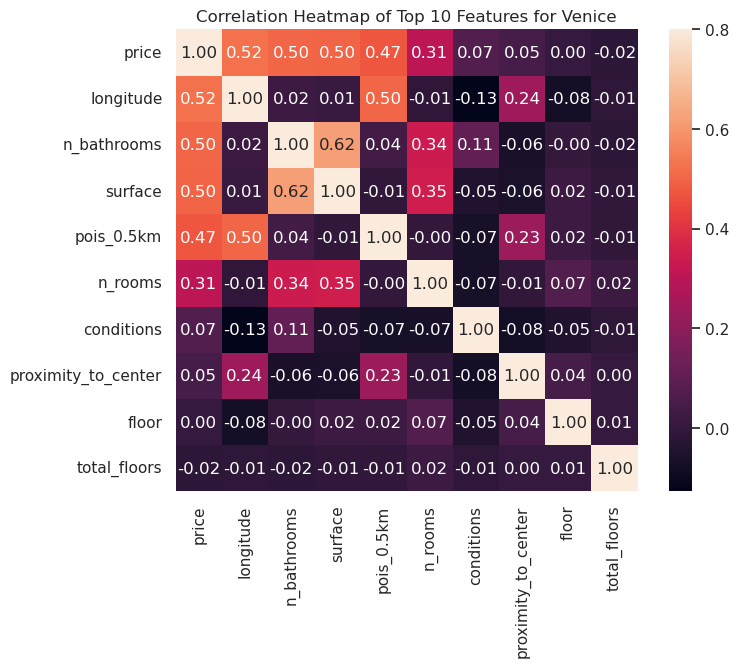

In [22]:
data = aug_train[aug_train['city'] == 'venice'].drop(['pois_2km', 'pois_5km',
       'pois_20km'], axis = 1)
corrmat = (data.iloc[: , 1:]).corr()
k = 10 #number of variables for heamap
cols = corrmat.nlargest(k, 'price')['price'].index
corrmat = (data[cols]).corr()
f, ax = plt.subplots(figsize=(8,6))
sns.set(font_scale=1)
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f');
ax.set_title(f"Correlation Heatmap of Top {k} Features for Venice")
plt.show()

<AxesSubplot:>

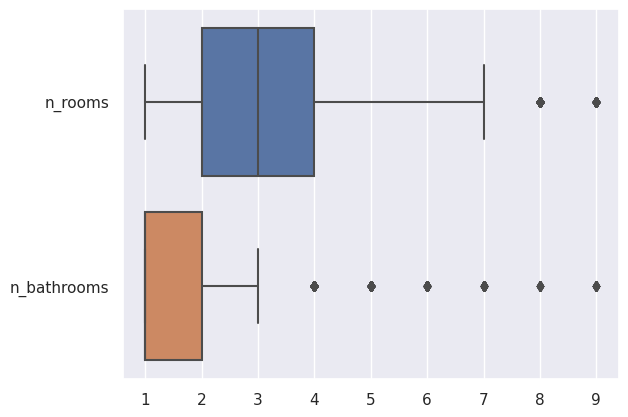

In [23]:
sns.boxplot(data=df_train[["n_rooms", "n_bathrooms"]], orient="h") # kinda uselesss

<a id="subsection-one-two"></a> 

---
## 1.2 - Data Cleaning

To clean the data, I will first look deal with missing values. There are some quick (imperfect, but acceptable) fixes available for some fields. For the rest, I will leave the job to **imputation**


duplicates

In [24]:
aug_train[aug_train.duplicated(['floor','latitude','longitude','city','price'])]

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,...,milan,rome,venice,center_dist,city,pois_0.5km,pois_2km,pois_5km,pois_10km,pois_20km
1820,28866,440000.0,True,NaN,1900.0,41.944900,12.555900,175.0,88.0,1.0,...,0.0,1.0,0.0,6.864524,rome,303.0,2125.0,30151.0,47896.0,27075.0
2126,49137,600000.0,True,3.0,NaN,45.440700,12.334800,NaN,NaN,1.0,...,0.0,0.0,1.0,0.534408,venice,4615.0,11657.0,5277.0,8558.0,3966.0
2549,42770,600000.0,True,3.0,NaN,45.426708,12.325110,NaN,NaN,2.0,...,0.0,0.0,1.0,0.572331,venice,3579.0,10861.0,7382.0,9234.0,3017.0
2941,34460,470000.0,True,3.0,1960.0,45.454884,9.154251,NaN,170.0,4.0,...,1.0,0.0,0.0,3.979950,milan,6410.0,30612.0,57505.0,67009.0,24903.0
3056,23323,399000.0,True,1.0,1980.0,41.857000,12.696100,175.0,0.0,0.0,...,0.0,1.0,0.0,21.910862,rome,0.0,0.0,0.0,1097.0,43699.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46227,46538,330000.0,True,1.0,NaN,41.868600,12.531100,175.0,70.0,7.0,...,0.0,1.0,0.0,3.667024,rome,961.0,13248.0,38932.0,46972.0,7437.0
46247,21236,380000.0,True,0.0,1960.0,41.915300,12.527800,175.0,95.0,4.0,...,0.0,1.0,0.0,3.385223,rome,593.0,12807.0,36791.0,50271.0,7088.0
46258,28573,129000.0,True,2.0,2000.0,41.888700,12.685500,175.0,15.0,1.0,...,0.0,1.0,0.0,20.649986,rome,0.0,0.0,0.0,3853.0,50482.0
46278,44751,189000.0,False,1.0,2008.0,45.493179,9.228240,NaN,80.0,-1.0,...,1.0,0.0,0.0,4.266226,milan,11240.0,32352.0,57131.0,62532.0,23184.0


In [25]:
aug_train = aug_train.drop_duplicates(['floor','latitude','longitude','city','price'])

### 1.2.2 Missing Data
#### Quick fixes

1. replacing  NaN balcony data with assumption of no balconies. reasonable since all current values are True.
2. replacing NaN garden data with assumption of no garden. same situation.
3. Encoding condition string with order rank, from worst conditions (0) to new (3)
4. dropping duplicates
5. getting rid of unreasonable values in different fields

---
4. [ ] Taking advantage of construction_year data for elevator, and viceversa 
5. [ ] taking advantage of floor data for total_floors, and viceversa

In [26]:
#missing data
data = aug_train
total_train = data.isnull().sum().sort_values(ascending=False)
percent_train = round( (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100, 1 )

data = aug_test
total_test = data.isnull().sum().sort_values(ascending=False)
percent_test = round( (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100, 1 )

missing_data = pd.concat([total_train, percent_train, total_test, percent_test], axis=1, 
                         keys=['Total missing (train)', '% missing (train)', 'Total missing (test)', '% missing (test)']); missing_data


,Total missing (train),% missing (train),Total missing (test),% missing (test)
energy_efficiency,19387,43.1,8570.0,43.3
total_floors,17885,39.8,7938.0,40.1
elevator,16942,37.7,7455.0,37.7
expenses,15629,34.8,6979.0,35.3
construction_year,13505,30.0,5964.0,30.1
n_bathrooms,2298,5.1,951.0,4.8
floor,1980,4.4,885.0,4.5
conditions,1203,2.7,513.0,2.6
surface,522,1.2,192.0,1.0
n_rooms,346,0.8,141.0,0.7


---
### Outliers

- [ ] TODO

In [27]:
data = aug_train
#standardizing data
price = data['price'][:,np.newaxis]
price_scaled = StandardScaler().fit_transform(data['price'][:,np.newaxis]);
price = data['price'][:,np.newaxis]

low_range_log = price_scaled[price_scaled[:,0].argsort()][:10]
high_range_log = price_scaled[price_scaled[:,0].argsort()][-10:]

print('outer range (low) of the distribution:')
print(low_range_log)
print('\nouter range (high) of the distribution:')
print(high_range_log)

low_range= price[price[:,0].argsort()][:10]
high_range= price[price[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-2.01508432]
 [-2.01218206]
 [-2.01013409]
 [-2.01013409]
 [-2.01013409]
 [-2.01013409]
 [-2.00954896]
 [-1.99316522]
 [-1.99258008]
 [-1.98965442]]

outer range (high) of the distribution:
[[1.49481637]
 [1.49481637]
 [1.49481637]
 [1.49481637]
 [1.49481637]
 [1.49481637]
 [1.49481637]
 [1.49481637]
 [1.49481637]
 [1.49481637]]
outer range (low) of the distribution:
[[ 154.]
 [ 650.]
 [1000.]
 [1000.]
 [1000.]
 [1000.]
 [1100.]
 [3900.]
 [4000.]
 [4500.]]

outer range (high) of the distribution:
[[600000.]
 [600000.]
 [600000.]
 [600000.]
 [600000.]
 [600000.]
 [600000.]
 [600000.]
 [600000.]
 [600000.]]


- Low range values are similar and not too far from 0.
- High range values are veeeery far off

In [28]:
# Sort the dataframe by 'price' column in descending order
df_sorted = aug_train.sort_values('price', ascending=False)

# Drop the 50 datapoints with the highest price
df_subset = df_sorted.drop(df_sorted.head(50).index)

# Sort the dataframe by 'price' column in ascending order
df_sorted = df_subset.sort_values('price', ascending=True)

# Drop the 2 datapoints with the lowest price
df_subset = df_sorted.drop(df_sorted.head(2).index)
aug_train = df_subset; aug_train.shape

#     # or  cap observations with low surface
#     data.loc[ data['surface'] <= 20, 'surface' ] = 20

(44901, 27)

In [29]:
# eliminating outliers in construction year, total floors, and floors.
aug_train = aug_train.drop(aug_train[aug_train['construction_year'] > 2025].index)
aug_train = aug_train.drop(aug_train[ aug_train['total_floors'] > 25].index)
aug_train = aug_train.drop(aug_train[ aug_train['floor'] > 25].index)

In [30]:
median = df_train["expenses"].quantile(q = 0.5)

q1= df_train["expenses"].quantile(q = 0.25)
q3= df_train["expenses"].quantile(q = 0.75)
iqr = q3 - q1

upper = q3 + 1.5*iqr; upper



# todo: check outliers in price too

315.0

In [31]:
df_train[df_train ["expenses"] > upper].shape[0]

1775

In [32]:
df_test[df_test["expenses"] > upper].shape[0]

770

---
## 1.3 - Hypothesis testing

a) normality

we have already noticed that house prices clearly violate this assumption. Another variable of interest in this respect is the surface of the house.

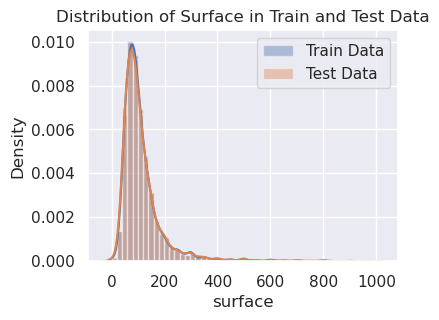

In [33]:
fig, ax = plt.subplots(figsize=(4,3))

sns.distplot(df_train['surface'], label='Train Data', ax=ax)
sns.distplot(df_test['surface'], label='Test Data', ax=ax)

ax.legend()
ax.set_title('Distribution of Surface in Train and Test Data')

plt.show()

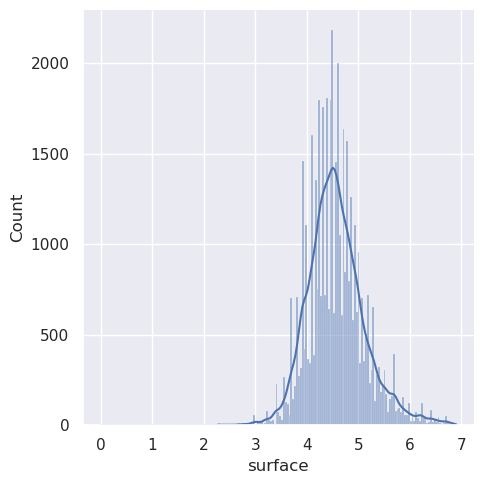

In [34]:
log_surf = np.log(df_train['surface'].replace(0,np.nan) ) # eliminate 0 surface (which makes no sense) # to plot lgo
sns.displot(log_surf , kde = True)

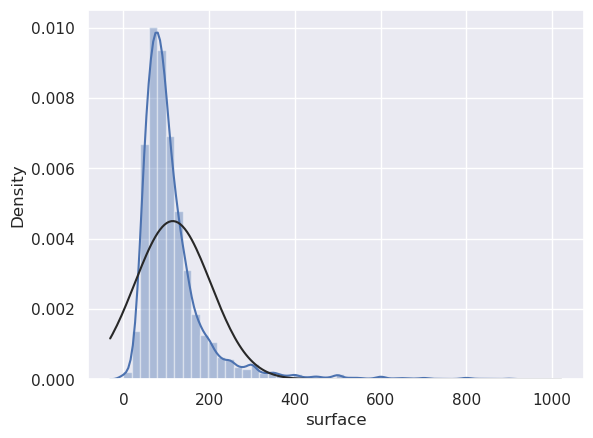

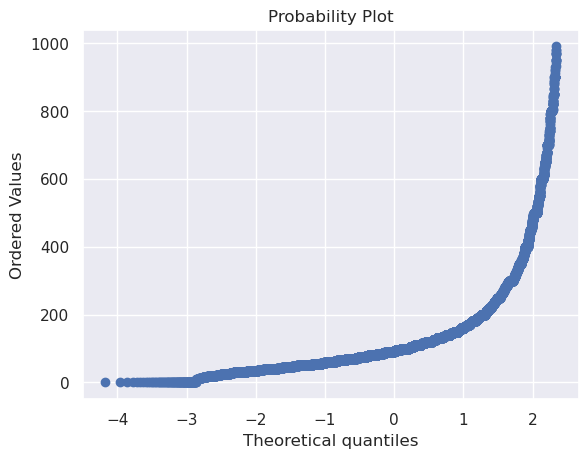

In [35]:
#histogram and normal probability plot
sns.distplot(df_train['surface'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['surface'], plot=plt)

clearly, the variable doesm't follow a normal distribution; however, applying a log transformation and dropping the (unreasonable) values of 0 surface leads to a close-to-normal distrubution

b) homoescedasticity

likewise, we'll analyze this assumption graphically. The 1st plot provided below shows an extremely cluttered nad unintelligible relation that hints heteroscedasticity when considering the "surface" of the houses. however, once again, the log of this variable seems to largely solve the issue. 

it is worth noting that the relationship after a log-transformation still reveals some strange characteristics in the data; specifically, observations around certain values of log surface (e.g. 3) show higher variance than the rest of the plot. 

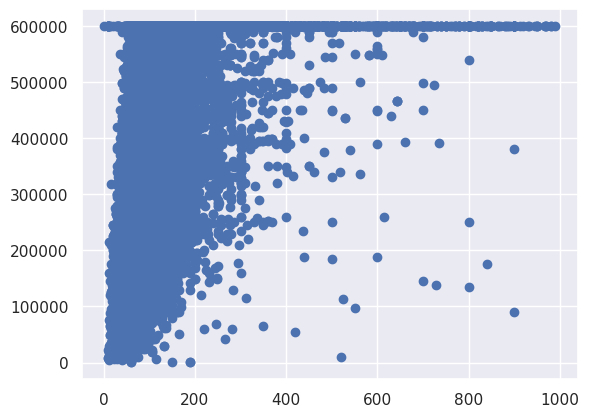

In [36]:
#scatter plot
data = aug_train
data['surface'] = data['surface'].clip(upper=6e+5)
# data.loc[ data['surface'] <= 20, 'surface' ] = 20
# data['price'] = data['price'].clip(lower=15)
plt.scatter(data['surface'], data['price']);
plt.show()

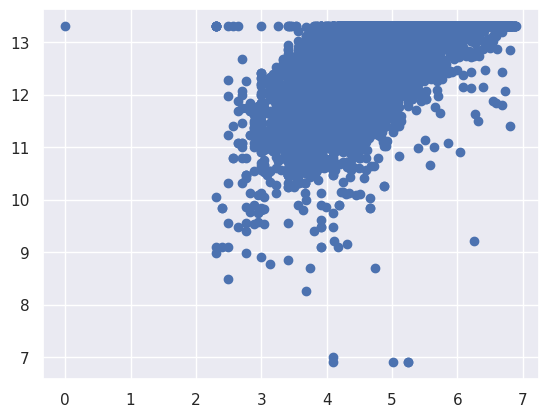

In [37]:
#scatter plot
data = aug_train
data['surface'] = data['surface'].clip(upper=6e+5)
# data.loc[ data['surface'] <= 20, 'surface' ] = 20
# data['price'] = data['price'].clip(lower=15)
plt.scatter(np.log(data['surface']), np.log(data['price']));

we will thus use the log-surface instead of the normal surface to make predictions, especially when it comes to linear models.

c) correlation between explanatory values

Dealing with this will mostly be done through inspection of the final correlation matrix (after full augmentation and imputation), followed by dropping some of the highly correlated variables. 

<a id="subsection-one-three"></a> 

| [back](#section-two) | [back to table of contents](#table) | [next](#section-three)|
 | - | ----------------------------------- | - |

---
## 1.3 Feature Augmentation

We start for adding a dummy variable for each of the 3 main cities: Milan, Rome, and Venice. together, they comprise around **99%** of the data

#### extra-feature 1 (3): dummy variable for milan, rome, and venice (one-hot encoding)

#### extra-feature 2): more accurate distance from city center

uses euclidean distance to approximate distances (in km) from city centers. uses the dummy variables created before for efficiency

---
#### extra-feature(s) 3: Counters for points of interest around x-km radius

In the preprocessing scirpt, I've defined a function that finds all nearby points of interest in an approximate radius of x km and adds the count as a new feature. 

*NB: evidently, the code is not near-efficient. however, it works. the function assumes the poi_dataset also has a dummy variable for cities, which can easily be created with the above-defined functions*

In [38]:
# data_ext = preprocess_houses(data, df_poi = df_poi, impute = False, impute_dummies = False, augment = True, add_pois = True, radii = [0.5,2,5,10,20])

<a id="section-two"></a> 


| [back](#section-one) | [back to table of contents](#table) | [next](#section-three)|
 | - | ----------------------------------- | - |

---
# Part 2: Models


relevant functions
- impute
- prep
- mods
- prep final

<a id="subsection-two-one"></a>
---

## 2.1 Splitting the data : Validation set and training set

In [39]:
# impute 
def impute(old_data, dummies = False):
    """
    input: dataframe with missing values
    
    output: COPY of dataframe with imputed values and dummy indicating imputation
    
    *NB: the original df won't be affected
    """
    data = old_data.copy()

    # Get names of columns with missing values
    # cols_with_missing = data.columns[data.isna().any()].tolist()
    
    # imputation into copy
    my_imputer = SimpleImputer()

   # Make new columns indicating what will be imputed (if True)
    if dummies:
        cols = pd.Index(['conditions', 'construction_year', 'latitude',
       'energy_efficiency', 'expenses', 'floor', 'n_bathrooms',
       'elevator', 'total_floors', 'n_rooms', 'surface'])
        cols = cols.intersection(data.columns)
        c = 0
        for col in cols:
            data[col + '_was_missing'] = old_data[col].isna()
            c += 1
        print(f"{c} dummies created for imputed vars!")

    # actually impute the data
    imputed_data = pd.DataFrame(my_imputer.fit_transform(data), columns= data.columns)
    
    return imputed_data

--- 
additional testing modifications

In [40]:
def mods1(old_data):
    """
    add final modifications here, like dropping certain columns and clipping certain values
    """

    data = old_data.copy()
    
    # cap observations with low surface
    data.loc[ data['surface'] <= 20, 'surface' ] = 20
    # TODO : add this to main function
    
    # when should I impute ?? 
    # columns that will be dropped
    drops = []
    drops_1 = ['energy_efficiency', 'expenses'] # ['city','energy_efficiency', 'expenses']
    drops_2 = ['center_dist', 'pois_2km', 'pois_5km','pois_20km', 'proximity_to_center']
    drops = drops_2
    data = data.drop(drops, axis  = 1)
    return data

In [41]:
def prep(dataset, testset, mods, city_split = False, dummies = True, validation = True):
    """
    receives both the dataset and the testset.  applies the modification function, imputation,
    and returns either the whole dataset or a split to validation and training set. 
    
    if city_split = True,
        the function is being used for training a model for each city. thus, the dummy city variables are not needed
    """
    drops =  ['city']
    if city_split == True:
        drops += ['milan', 'rome', 'venice']
        
    X = dataset.drop(drops + ['price','id'], axis = 1)
    
    X[['garden','balcony']] = X[['garden','balcony']].astype(int)
    y = dataset['price']
    
    X_test = testset.drop(drops, axis = 1)
    X_test[['garden','balcony']] = X_test[['garden','balcony']].astype(int)

    X = mods(X)
    X_test = mods(X_test)    

    if validation:
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
        X_train_imputed = impute(X_train,dummies)
        X_val_imputed = impute(X_val, dummies)
        X_test_imputed = impute (X_test, dummies)
        return X_train_imputed, X_val_imputed, y_train, y_val, X_test_imputed
    
    else:
        X_imputed = impute(X,dummies)
        X_test_imputed = impute (X_test, dummies)
        return X_imputed, y,  X_test_imputed

<a id="subsection-two-two"></a> 


| [back](#section-two) | [back to table of contents](#table) | [next](#section-three)|
 | - | ----------------------------------- | - |

---
## 2.2 Metrics




 ---



In [42]:
def train_test_score():
    # collect MSE on both train and test data
    mse_val = mean_squared_error(pred_val, y_val)
    mse_train = mean_squared_error(pred_train, y_train)
    ratio = mse_val/mse_train
    # collect data in lists
    preds_train.append(pred_train)
    preds_val.append(pred_val)
    errors_train.append(mse_train)
    errors_val.append(mse_val)
    ratios.append(ratio)

    # metrics
    print(f"ratio: Validation MSE {ratio: .3} higher than train MSE")
    print(f"MSE train: {mse_train: .3}",
          f"MSE validation: {mse_val: .3}")
    print(f"MAE train: {mean_absolute_error(pred_train, y_train): .3}",
          f"MAE validation: {mean_absolute_error(pred_val, y_val): .3}")
    
    

<a id="subsection-two-two"></a> 


| [back](#section-two) | [back to table of contents](#table) | [next](#section-three)|
 | - | ----------------------------------- | - |

---
## 2.2 Model training 

In this section we train and compare the following models:
1.  Linear regressor (scikitlearn)
2.  random forest (scikitlearn)
3.  Boosting XGB (scikitlearn)
4.  Neural network (tensorflow)
5. seperate models per city

 ---
*note* tensorflow random forest yielded the following: 
we observed a mean squared error of about 799, 260, 803, 072.0000. 

---

### 2.2.1 Classic Linear Regression

In [43]:
X_train, X_val, y_train, y_val, X_test = prep(aug_train, aug_test, mods = mods1, dummies = True)
lin_model = LinearRegression()

lin_model.fit(X_train, y_train)

pred_train = lin_model.predict(X_train)
pred_val = lin_model.predict(X_val)


mse_val = mean_squared_error(pred_val, y_val)
mse_train = mean_squared_error(pred_train, y_train)
print(f"ratio: Validation MSE {mse_val/mse_train} higher than train MSE")
print(f"MSE train: {mse_train: .3}",
      f"MSE validation: {mse_val: .3}")
print(f"MAE train: {mean_absolute_error(pred_train, y_train): .3}",
      f"MAE validation: {mean_absolute_error(pred_val, y_val): .3}")

11 dummies created for imputed vars!
11 dummies created for imputed vars!
11 dummies created for imputed vars!
ratio: Validation MSE 1.0209292749717005 higher than train MSE
MSE train:  1.18e+10 MSE validation:  1.21e+10
MAE train:  8.51e+04 MAE validation:  8.6e+04


In [44]:
X, y, X_test = prep(aug_train, aug_test, mods = mods1, dummies = True, validation = False)

score = cross_val_score(lin_model,X,y, scoring = "neg_mean_squared_error"); -score

11 dummies created for imputed vars!
11 dummies created for imputed vars!


array([2.36954881e+10, 1.00057420e+10, 6.79418273e+09, 1.47583254e+10,
       3.04362120e+10])

note: High Variance!!


| [back](#section-two) | [back to table of contents](#table) | [next](#section-three)|
 | - | ----------------------------------- | - |
---

### 2.2.2 Random Forest

*note* : I ran cross-validation for a wide rande of parameters. due to the time it takes to run this operation, I do not include the cell in this notebook; however, I provide the results

In [45]:
# Create a dictionary of hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200, 300], # number of trees in the forest
    'max_depth': [5,10, 20, 30], # maximum depth of the tree
    'min_samples_split': [2, 5, 10], # minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4] # minimum number of samples required to be at a leaf node
}

# # Create a random forest regressor
# rf = RandomForestRegressor(warm_start=True, verbose = 0)

# # Create a grid search object with 5-fold cross-validation
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# # Fit the grid search to the training data
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters from the grid search
# best_params = grid_search.best_params_

# # Create a new random forest regressor with the best hyperparameters
# rf = RandomForestRegressor(**best_params, warm_start=True)

# # Fit the new random forest to the training data
# rf.fit(X_train, y_train)

# # Make predictions on the validation set
# rf_pred = rf.predict(X_val)

In [46]:
# output: Mean Squared Error:  5.47e+10 (on validation set) !!! wasn't reproducible later on

best_params = {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [47]:
X_train, X_val, y_train, y_val, X_test = prep(aug_train, aug_test, mods = mods1, dummies = True, validation = True)

rf = RandomForestRegressor(**best_params)

rf.fit(X_train, y_train)

pred_train = rf.predict(X_train)
pred_val = rf.predict(X_val)
# print(f"Mean Squared Error: {mean_squared_error(np.exp(pred), np.exp(y_val)): .3}")
mse_val = mean_squared_error(pred_val, y_val)
mse_train = mean_squared_error(pred_train, y_train)
print(f"ratio: Validation MSE {mse_val/mse_train} higher than train MSE")
print(f"MSE train: {mse_train: .3}",
      f"MSE validation: {mse_val: .3}")
print(f"MAE train: {mean_absolute_error(pred_train, y_train): .3}",
      f"MAE validation: {mean_absolute_error(pred_val, y_val): .3}")

11 dummies created for imputed vars!
11 dummies created for imputed vars!
11 dummies created for imputed vars!
ratio: Validation MSE 7.55285723141929 higher than train MSE
MSE train:  4.85e+08 MSE validation:  3.66e+09
MAE train:  1.43e+04 MAE validation:  4.04e+04


In [48]:
# comparison with random forest of decision stumps
X_train, X_val, y_train, y_val, X_test = prep(aug_train, aug_test, mods = mods1, dummies = True)
model = RandomForestRegressor(max_depth = 1, warm_start = True)

model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
# print(f"Mean Squared Error: {mean_squared_error(np.exp(pred), np.exp(y_val)): .3}")
mse_val = mean_squared_error(pred_val, y_val)
mse_train = mean_squared_error(pred_train, y_train)
print(f"ratio: Validation MSE {mse_val/mse_train} higher than train MSE")
print(f"MSE train: {mse_train: .3}",
      f"MSE validation: {mse_val: .3}")
print(f"MAE train: {mean_absolute_error(pred_train, y_train): .3}",
      f"MAE validation: {mean_absolute_error(pred_val, y_val): .3}")

11 dummies created for imputed vars!
11 dummies created for imputed vars!
11 dummies created for imputed vars!
ratio: Validation MSE 0.9713613465519998 higher than train MSE
MSE train:  1.88e+10 MSE validation:  1.82e+10
MAE train:  1.13e+05 MAE validation:  1.12e+05


| [back](#section-two) | [back to table of contents](#table) | [next](#section-three)|
 | - | ----------------------------------- | - |
---


## 2.2.3 Boosting

In [49]:
X_train, X_val, y_train, y_val, X_test = prep(aug_train, aug_test, mods = mods1, dummies = True)
model = xgb()
model.fit(X_train, y_train) 

pred_train = model.predict(X_train)
pred_val = model.predict(X_val)


mse_val = mean_squared_error(pred_val, y_val)
mse_train = mean_squared_error(pred_train, y_train)

print(f"ratio: Validation MSE {mse_val/mse_train} higher than train MSE")
print(f"MSE train: {mse_train: .3}",
      f"MSE validation: {mse_val: .3}")
print(f"MAE train: {mean_absolute_error(pred_train, y_train): .3}",
      f"MAE validation: {mean_absolute_error(pred_val, y_val): .3}")

11 dummies created for imputed vars!
11 dummies created for imputed vars!
11 dummies created for imputed vars!
ratio: Validation MSE 1.712209959170657 higher than train MSE
MSE train:  2.34e+09 MSE validation:  4.01e+09
MAE train:  3.47e+04 MAE validation:  4.42e+04


In [50]:
X_train, X_val, y_train, y_val, X_test = prep(aug_train, aug_test, mods = mods1, dummies = True)
model = xgb(max_depth = 5, eta = 0.05)
model.fit(X_train, y_train) 

pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
# print(f"Mean Squared Error: {mean_squared_error(np.exp(pred), np.exp(y_val)): .3}")
mse_val = mean_squared_error(pred_val, y_val)
mse_train = mean_squared_error(pred_train, y_train)
# error = mean_squared_error(np.exp(pred), np.exp(y_val) )
# print(f"Mean Squared Error: {error: .3}")
print(f"ratio: Validation MSE {mse_val/mse_train} higher than train MSE")
print(f"MSE train: {mse_train: .3}",
      f"MSE validation: {mse_val: .3}")
print(f"MAE train: {mean_absolute_error(pred_train, y_train): .3}",
      f"MAE validation: {mean_absolute_error(pred_val, y_val): .3}")

11 dummies created for imputed vars!
11 dummies created for imputed vars!
11 dummies created for imputed vars!
ratio: Validation MSE 1.0988169795789244 higher than train MSE
MSE train:  4.85e+09 MSE validation:  5.33e+09
MAE train:  4.99e+04 MAE validation:  5.25e+04


| [back](#section-two) | [back to table of contents](#table) | [next](#section-three)|
 | - | ----------------------------------- | - |
---


## 2.2.4 Deep NN

the following section is quite incomplete. for the moment, I'm using keras; however, I would also like to try using pytorch

In [51]:
# Define the model architecture
def nn(X_train, y_train):
    dnn = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer='l1_l2'), # both l1 and l2 regularization selected
        keras.layers.Dense(32, activation='relu', kernel_regularizer='l1_l2'),
        keras.layers.Dense(1)
    ])

    # Compile the model with loss function and optimizer
    dnn.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the model to the training data
    dnn.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    return dnn

In [52]:
# Evaluate the model on the test data
def nn_error(dnn, X, y):
    test_loss = dnn.evaluate(X, y, verbose=0)
    print(f'MSE: {test_loss:.3}')
    return test_loss

In [53]:
X_train, X_val, y_train, y_val, X_test = prep(aug_train, aug_test, mods = mods1, dummies = True)
model = nn(X_train,y_train)
mse_train = nn_error(model, X_train, y_train)
mse_val = nn_error(model, X_val,y_val)
print(f"ratio: Validation MSE {mse_val/mse_train} higher than train MSE")

11 dummies created for imputed vars!
11 dummies created for imputed vars!
11 dummies created for imputed vars!
MSE: 8.47e+09
MSE: 2.15e+10
ratio: Validation MSE 2.535885482083398 higher than train MSE


| [back](#section-two) | [back to table of contents](#table) | [next](#section-three)|
 | - | ----------------------------------- | - |
---


## 2.2.5 Seperate Models for each city

the following section is quite incomplete. for the moment, I'm using keras; however, I would also like to try using pytorch

In [54]:
def mods2(old_data):
    # add final modifications here
    data = old_data.copy()
    
    # cap observations with low surface
    data.loc[ data['surface'] <= 20, 'surface' ] = 20
  
    drops_2 = ['center_dist', 'pois_2km', 'pois_5km','pois_20km', 'proximity_to_center']
    drops = drops_2
    
    data = data.drop(drops, axis  = 1)
    return data

In [55]:
df_aug = aug_train.copy()
test_aug = aug_test.copy()

df_aug['price'] = np.log(df_aug['price'])

In [56]:
cities = ["milan", "rome", "venice"]
models = dict()
general = xgb(eta = 0.05, alpha = 0.5)

for city in cities:
    models[city] =  LinearRegression()# xgb(eta = 0.05, alpha = 0.5)

    
preds_train = []
preds_val = []
errors_train = []
errors_val = []
ratios = []

for city, model in models.items():
    # look at data of that city
    data = df_aug[df_aug[city] == 1]
    test = test_aug[test_aug[city] == 1]
    
    # split int otrain and validation set
    X_train, X_val, y_train, y_val, X_test = prep(data, test, mods = mods2, city_split = True, dummies = True)
    
    model.fit(X_train, y_train)
    print(f"{city} fitted!")
    
    # collect predictions on both train and test data
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    
    # exponantiate to provide the correct metric
    pred_train, pred_val = np.exp(pred_train), np.exp(pred_val)
    y_train, y_val = np.exp(y_train), np.exp(y_val)

    # collect MSE on both train and test data
    mse_val = mean_squared_error(pred_val, y_val)
    mse_train = mean_squared_error(pred_train, y_train)
    ratio = mse_val/mse_train
    # collect data in lists
    preds_train.append(pred_train)
    preds_val.append(pred_val)
    errors_train.append(mse_train)
    errors_val.append(mse_val)
    ratios.append(ratio)

    # metrics
    print(f"ratio {city}: Validation MSE {ratio: .3} higher than train MSE")
    print(f"MSE train: {mse_train: .3}",
          f"MSE validation: {mse_val: .3}")
    print(f"MAE train: {mean_absolute_error(pred_train, y_train): .3}",
          f"MAE validation: {mean_absolute_error(pred_val, y_val): .3}\n\n")
                        
                    


11 dummies created for imputed vars!
11 dummies created for imputed vars!
11 dummies created for imputed vars!
milan fitted!
ratio milan: Validation MSE  0.937 higher than train MSE
MSE train:  2.18e+10 MSE validation:  2.04e+10
MAE train:  1.02e+05 MAE validation:  1e+05


11 dummies created for imputed vars!
11 dummies created for imputed vars!
11 dummies created for imputed vars!
rome fitted!
ratio rome: Validation MSE  0.954 higher than train MSE
MSE train:  1.7e+10 MSE validation:  1.62e+10
MAE train:  8.21e+04 MAE validation:  8.26e+04


11 dummies created for imputed vars!
11 dummies created for imputed vars!
11 dummies created for imputed vars!
venice fitted!
ratio venice: Validation MSE  0.969 higher than train MSE
MSE train:  2.29e+10 MSE validation:  2.22e+10
MAE train:  8.84e+04 MAE validation:  9.02e+04




In [57]:
# identify 10 test datapoints without location information
no_location = test_aug[test_aug['latitude'].isna()]
ids_nan = no_location['id']; ids_nan

2290      7321
5976     55700
6983     21604
8043     42657
8245     62480
8399      2983
8463     50971
16063    33945
18037     7697
18731    34866
Name: id, dtype: int64

| [back](#section-two) | [back to table of contents](#table) | [next](#section-three)|
 | - | ----------------------------------- | - |
---


## 2.2.6. Ensemble

the following section is quite incomplete. for the moment, I'm using keras; however, I would also like to try using pytorch

<a id="subsection-two-three"></a>

| [back](#section-two) | [back to table of contents](#table) | [next](#section-three)|
 | - | ----------------------------------- | - |
---


## 2.3 Comparing models


In [58]:
best_model = ... # TODO

| [back](#section-two) | [back to table of contents](#table) | [next](#section-three)|
 | - | ----------------------------------- | - |
---


# 2.4 Model Explainability

Inspector is a method taht helps us look at which variables influenced the model the most.

In [59]:
# TO DO

<a id="section-three"></a> 

| [back](#section-two) | [back to table of contents](#table) | [next](#section-three)|
 | - | ----------------------------------- | - |
---

# Part 3: Submission

In [60]:
X, y, X_test = prep(aug_train, aug_test, mods = mods1, dummies = True, validation = False)

rf = RandomForestRegressor(**best_params, warm_start = True)

rf.fit(X, y)

pred_train = rf.predict(X)
# print(f"Mean Squared Error: {mean_squared_error(np.exp(pred), np.exp(y_val)): .3}")
mse_train = mean_squared_error(pred_train, y)

print(f"MSE train: {mse_train: .3}")
print(f"MAE train: {mean_absolute_error(pred_train, y): .3}")

11 dummies created for imputed vars!
11 dummies created for imputed vars!
MSE train:  4.55e+08
MAE train:  1.38e+04


In [61]:
score = cross_val_score(rf,X,y, scoring = "neg_mean_squared_error"); -score # still some high variance, but definitely reduced

array([1.44676386e+10, 5.21022627e+09, 5.99202201e+09, 1.02498574e+10,
       2.13482873e+10])

In [62]:
ids = X_test['id'].astype('int32')
X_test = X_test.drop('id', axis = 1)
pred_test = rf.predict(X_test)

In [63]:
output = pd.DataFrame({'id': ids, 'price': pred_test.squeeze()})
output.to_csv('/kaggle/working/final_submission.csv', index= False)